# IOR plots

In [2]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

In [3]:
def bw_ios2(filename, option):
    '''
    Function to read BW or IOPS from a log file
    '''
    fopen = open(filename, mode='r+' )
    fread = fopen.readlines()
    value = []
    for line in fread:
        if option in line:
            raw = line.split()
            if len(raw)>11:
                bw, iop =  float(raw[3]), float(raw[7]) 
    return bw, iop

In [4]:
def plot_bw_iops(HOME, nodes, fiojobs, mode):
    '''
    Function to plot total BW & IOPS using HOME files for n nodes and n fio_jobs
    '''
    histo_bw = []
    histo_iops= []
    data = {}

    data['histo'] = []
    
    for fjob in fiojobs:
        total_flow = []
        total_fio_bw = []
        total_fio_iops = []
        
        for node in nodes:
            path=HOME+str(node)+'_node/'
            content=os.listdir(path)
            fiojob = [s for s in content if "_"+str(fjob)+"_iort" in s]
            
            if len(fiojob)>1:
                if len(fiojob[0])<len(fiojob[1]): fiojob=fiojob[0]
                else: fiojob = fiojob[1]
            else:
                fiojob= fiojob[0]
            
            fio_bw = 0
            fio_iops = 0
            fio_jobs = 0
            
            for folder in os.listdir(path+fiojob):

                bw, iops= bw_ios2(path+fiojob+"/"+folder+"/output.log",mode) #in Mb/s
                #fio_iops+= bw_ios3(path+fiojob+"/"+folder+"/output.log", "read")    #in k
                fio_bw+=bw
                fio_iops+=iops             
                
            total_fio_bw.append(fio_bw)
            total_fio_iops.append(fio_iops)
            histo_bw.append(fio_bw)
            histo_iops.append(fio_iops)

        #plt.plot(nodes,total_flow, '--',label='fio_tjob='+str(fjob))
        data[str(fjob)]=[]
        data[str(fjob)].append({'bw': total_fio_bw, 'iop':total_fio_iops })
    
    data['histo'].append({'bw':histo_bw, 'iop':histo_iops})  
    with open(HOME+'data_'+mode+'.txt', 'w') as outfile:
        json.dump(data, outfile,  indent=4)
    
    plots(HOME+'data_'+mode+'.txt', nodes, fiojobs)        

In [5]:
def plots(filename, nodes, fiojobs, label='ior_ts'):
    with open(filename) as json_file:
        data = json.load(json_file)
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 6))
        for fiojob in fiojobs:
            ax[0].plot(nodes[:len(data[fiojob][0]['bw'])],np.array(data[fiojob][0]['bw'])*1.07374/1000,'o--',label=label+'='+str(fiojob))
            ax[1].plot(nodes[:len(data[fiojob][0]['iop'])],np.array(data[fiojob][0]['iop'])/1000,'o--',label=label+'='+str(fiojob))
        ax[0].legend()
        ax[0].set_xticks(nodes)
        ax[0].set_xlabel('nodes', size=16)
        ax[0].set_ylabel('GB/s', size=16)
        ax[0].set_title("Total Bandwidth vs. n nodes", size=20)

        ax[1].legend()
        ax[1].set_xticks(nodes)
        ax[1].set_xlabel('nodes')
        ax[1].set_ylabel('kIOPS')
        ax[1].set_title("Total IOPS vs. n nodes")
        plt.show()
        plot_3d(nodes, fiojobs, np.array(data['histo'][0]['bw'])/1000, label2=label)

In [6]:

def plot_3d(nodes, numjobs, data, label2='iort'):
    """This function is responsible for plotting the entire 3D plot."""

    iodepth = nodes
    z_axis_label = 'GB/s'
    
    fig = plt.figure()
    ax1 = fig.add_subplot(projection="3d", elev=25)
    fig.set_size_inches(15, 10)
    ax1.set_box_aspect((4, 4, 3), zoom=1.2)

    lx = len(nodes)
    ly = len(numjobs)

    n = np.array(data, dtype=float)

    if lx < ly:
        size = ly * 0.03  # thickness of the bar
    else:
        size = lx * 0.05  # thickness of the bar

    xpos_orig = np.arange(0, lx, 1)
    ypos_orig = np.arange(0, ly, 1)

    xpos = np.arange(0, lx, 1)
    ypos = np.arange(0, ly, 1)
    xpos, ypos = np.meshgrid(xpos - (size / lx), ypos - (size * (ly / lx)))

    xpos_f = xpos.flatten()  # Convert positions to 1D array
    ypos_f = ypos.flatten()

    zpos = np.zeros(lx * ly)

    # Positioning and sizing of the bars
    dx = size * np.ones_like(zpos)
    dy = size * (ly / lx) * np.ones_like(zpos)
    dz = n.flatten(order="F")
    values = dz / (dz.max() / 1)

    # Create the 3D chart with positioning and colors
    cmap = plt.get_cmap("rainbow", xpos.ravel().shape[0])
    colors = cm.rainbow(values)
    ax1.bar3d(xpos_f, ypos_f, zpos, dx, dy, dz, color=colors, zsort="max")

    # Create the color bar to the right
    norm = mpl.colors.Normalize(vmin=0, vmax=dz.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    res = fig.colorbar(sm, fraction=0.046, pad=0.19)
    res.ax.set_title('BW')

    # Set tics for x/y axis
    float_x = [float(x) for x in (xpos_orig)]

    ax1.w_xaxis.set_ticks(float_x)
    ax1.w_yaxis.set_ticks(ypos_orig)
    ax1.w_xaxis.set_ticklabels(iodepth)
    ax1.w_yaxis.set_ticklabels(numjobs)

    # axis labels
    fontsize = 16
    ax1.set_xlabel("nodes", fontsize=fontsize)
    ax1.set_ylabel(label2, fontsize=fontsize)
    ax1.set_zlabel('Bandwidth GB/s', fontsize=fontsize)

    [t.set_verticalalignment("center_baseline") for t in ax1.get_yticklabels()]
    [t.set_verticalalignment("center_baseline") for t in ax1.get_xticklabels()]

    ax1.zaxis.labelpad = 25

    tick_label_font_size = 12
    for t in ax1.xaxis.get_major_ticks():
        t.label.set_fontsize(tick_label_font_size)

    for t in ax1.yaxis.get_major_ticks():
        t.label.set_fontsize(tick_label_font_size)

    ax1.zaxis.set_tick_params(pad=10)
    for t in ax1.zaxis.get_major_ticks():
        t.label.set_fontsize(tick_label_font_size)


    plt.show()

# transferSize = 2m, numTasks =32, BS = ?

## READ

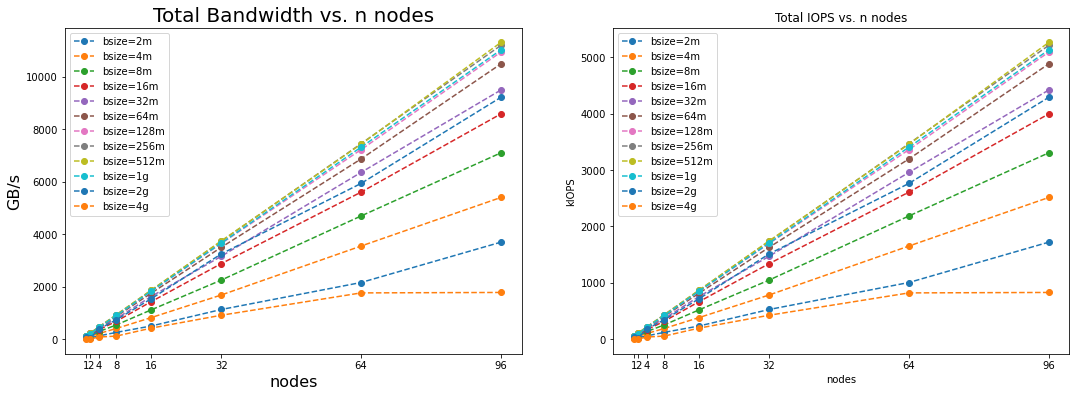

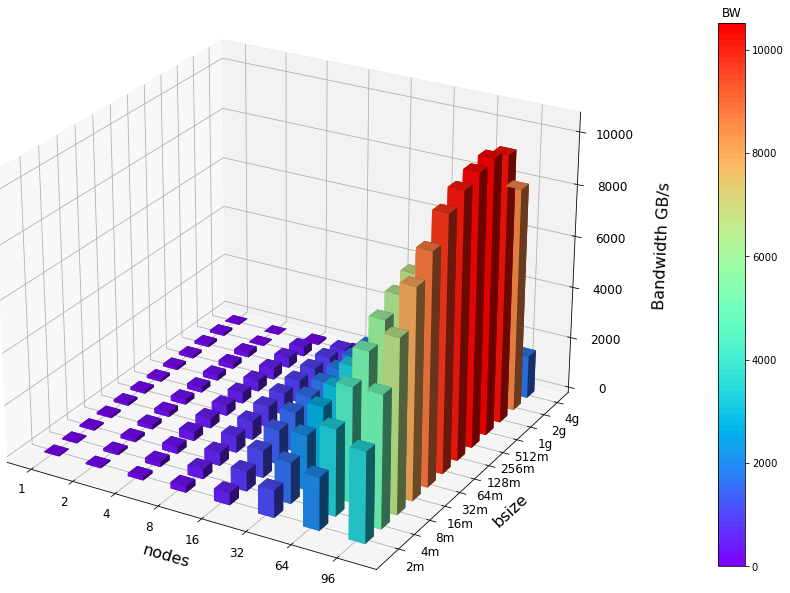

In [12]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_n_fsize_32_task_2m_ts/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
bs = ['2m', '4m', '8m', '16m', '32m', '64m', '128m', '256m', '512m', '1g', '2g', '4g']
plots(HOME_seqread+'data_'+'read'+'.txt', nodes, bs, label='bsize')

## WRITE

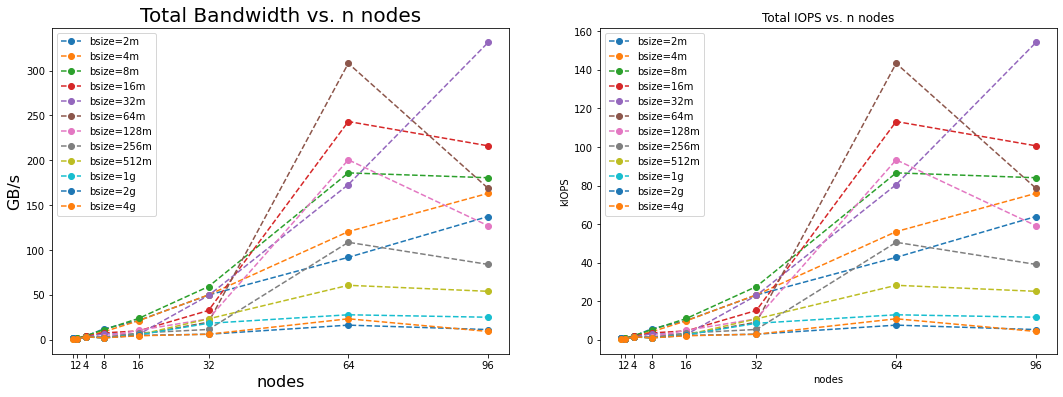

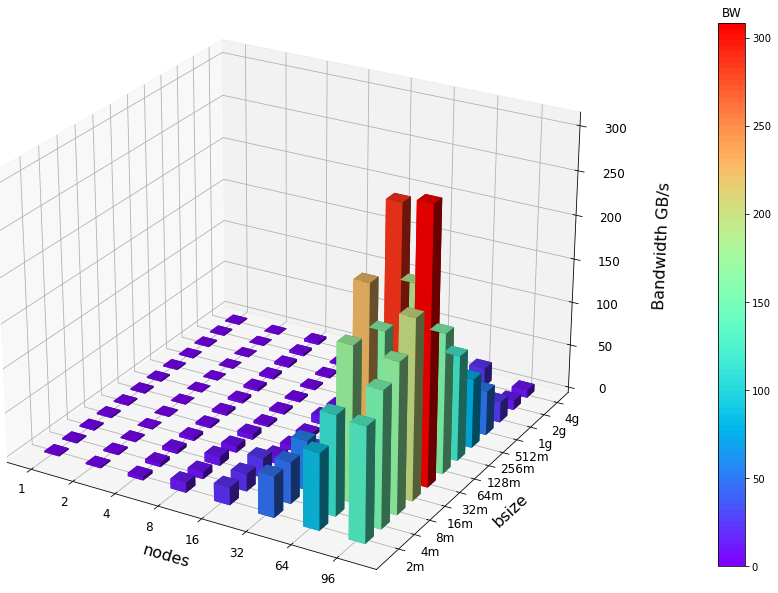

In [13]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_n_fsize_32_task_2m_ts/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
bs = ['2m', '4m', '8m', '16m', '32m', '64m', '128m', '256m', '512m', '1g', '2g', '4g']
plots(HOME_seqread+'data_'+'write'+'.txt', nodes, bs, label='bsize')

# transferSize = 1m, numTasks =4, BS = ?

## READ

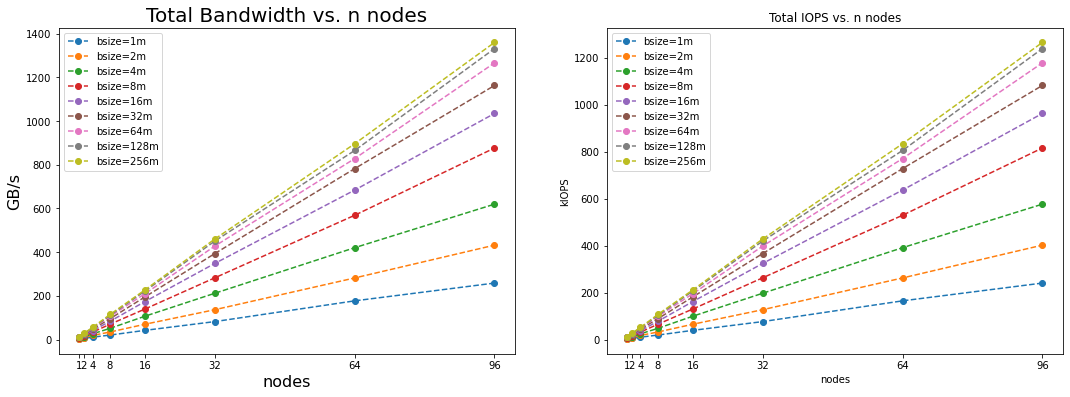

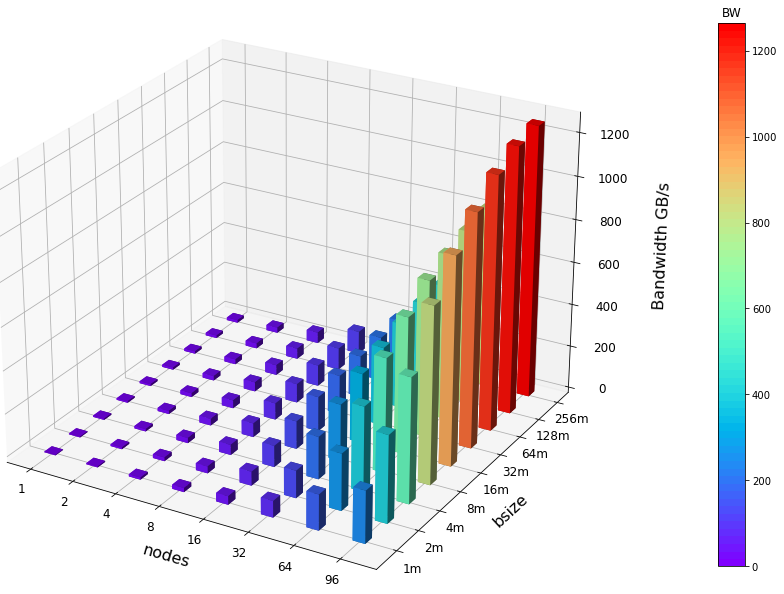

In [14]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_n_fsize_4_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
bs = ['1m', '2m', '4m', '8m', '16m', '32m', '64m', '128m', '256m']
plots(HOME_seqread+'data_'+'read'+'.txt', nodes, bs, label='bsize')

## WRITE

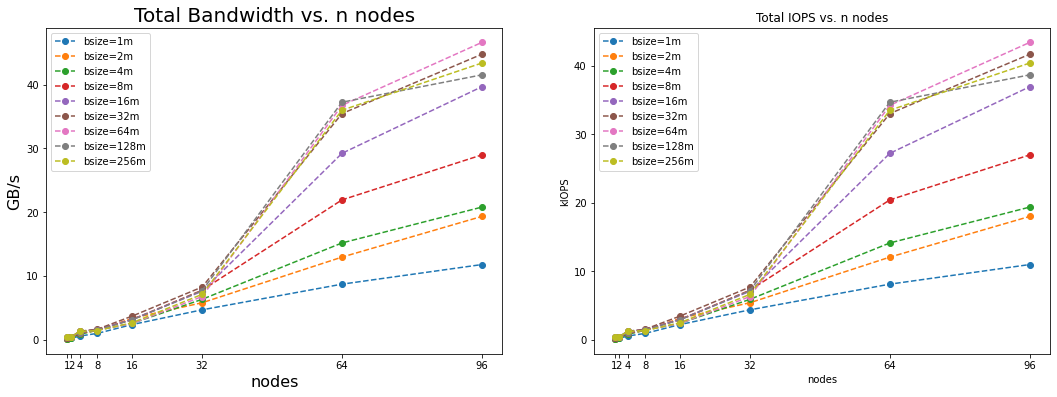

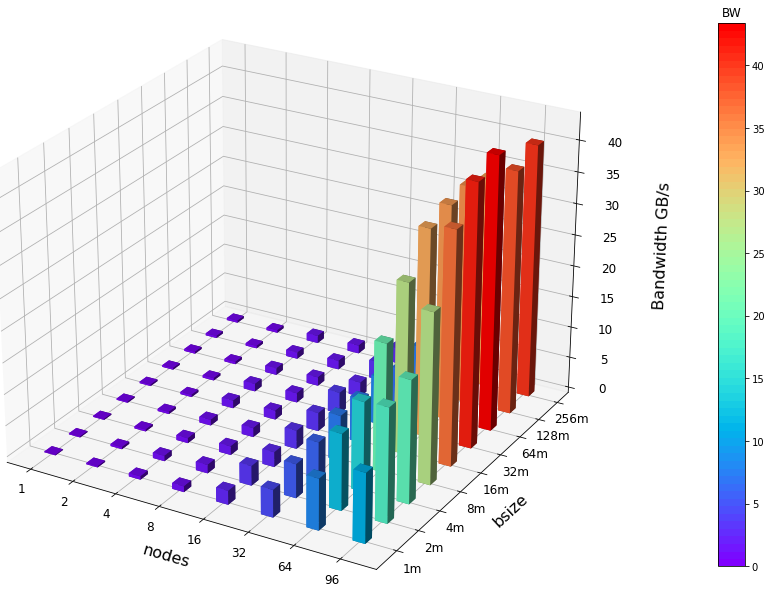

In [15]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_n_fsize_4_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
bs = ['1m', '2m', '4m', '8m', '16m', '32m', '64m', '128m', '256m']
plots(HOME_seqread+'data_'+'write'+'.txt', nodes, bs, label='bsize')

# BS = 4m, transferSize = 64K, numTasks =?

## READ

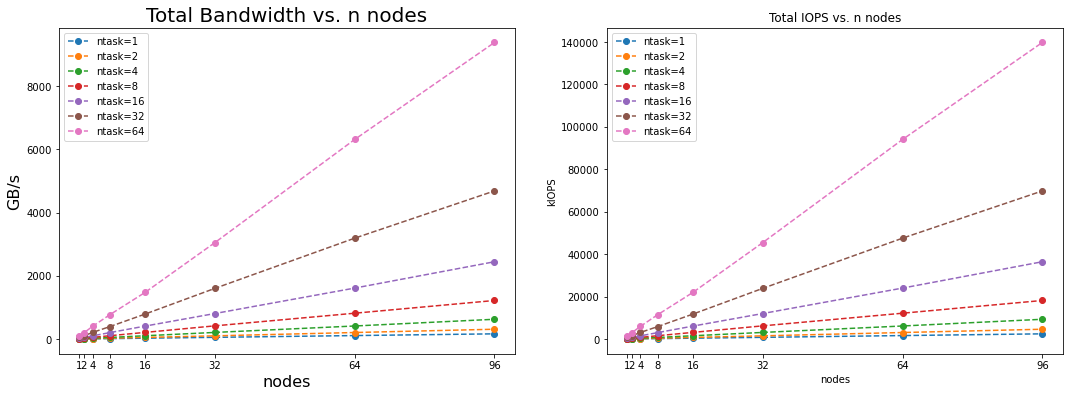

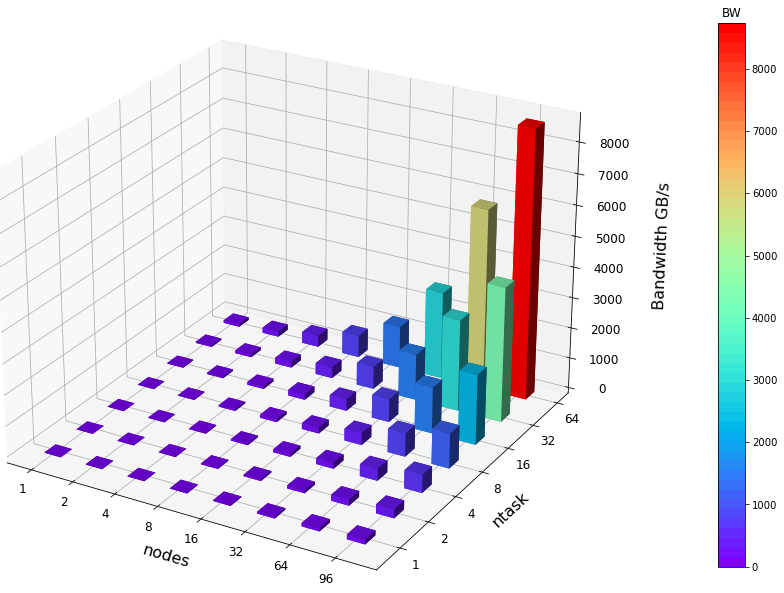

In [22]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_n_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
ntask = ['1', '2', '4', '8', '16', '32', '64']
plots(HOME_seqread+'data_'+'read'+'.txt', nodes, ntask, label='ntask')

## WRITE

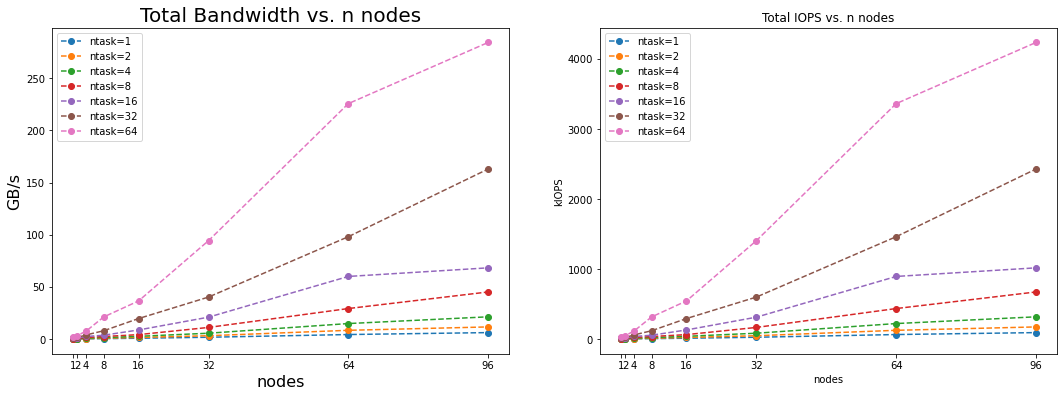

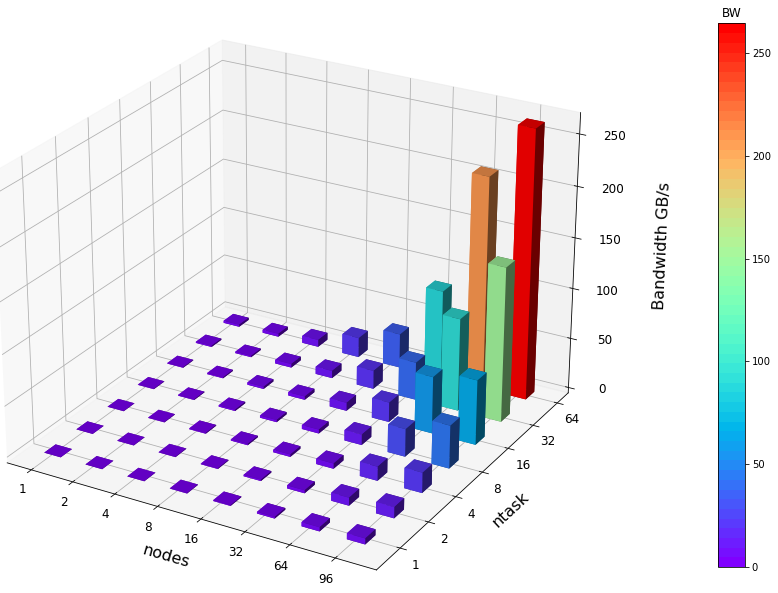

In [23]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_n_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
ntask = ['1', '2', '4', '8', '16', '32', '64']
plots(HOME_seqread+'data_'+'write'+'.txt', nodes, ntask, label='ntask')

# BS = 4m, numTasks =1, transferSize =?

## READ

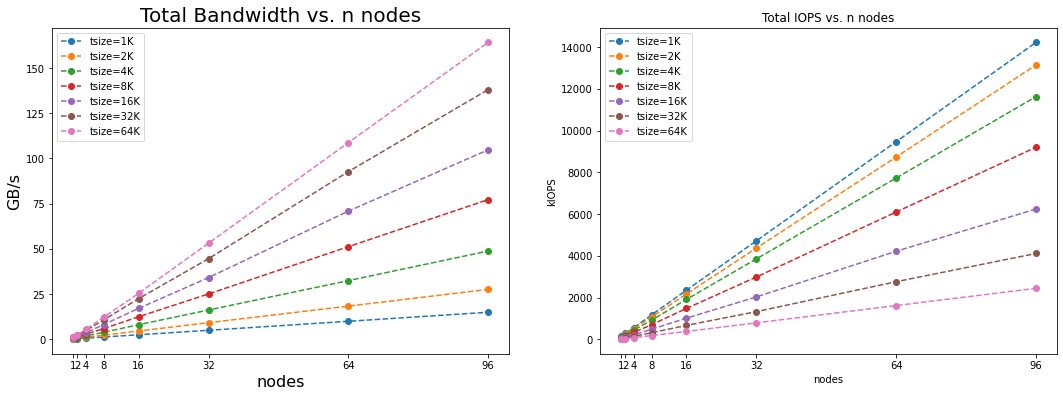

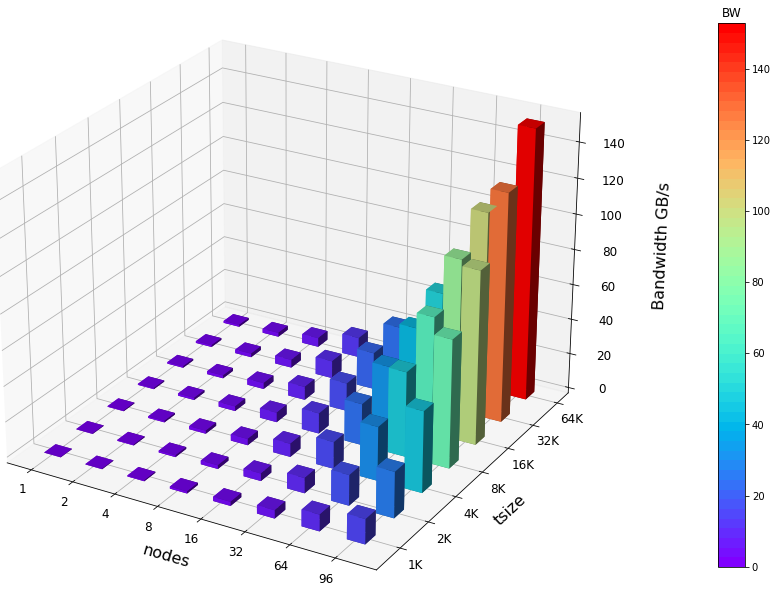

In [6]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_1_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
tsize = ['1K', '2K', '4K', '8K', '16K', '32K', '64K']
plots(HOME_seqread+'data_'+'read'+'.txt', nodes, tsize, 'tsize')

## WRITE

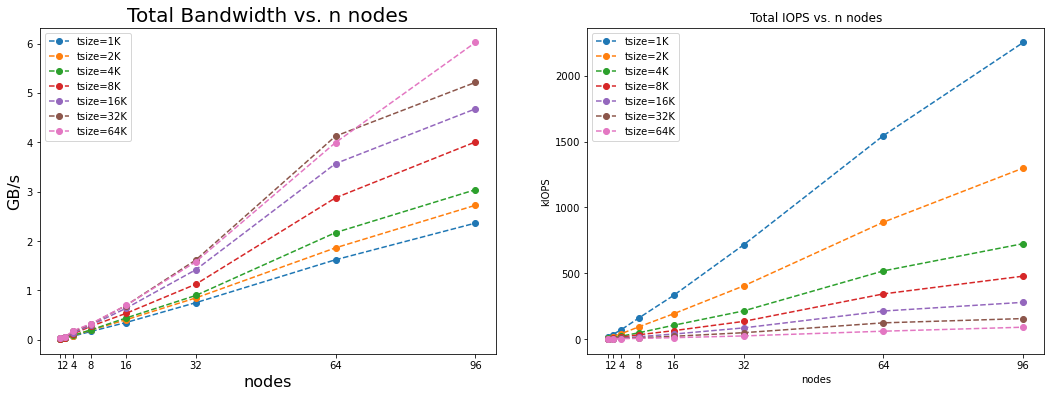

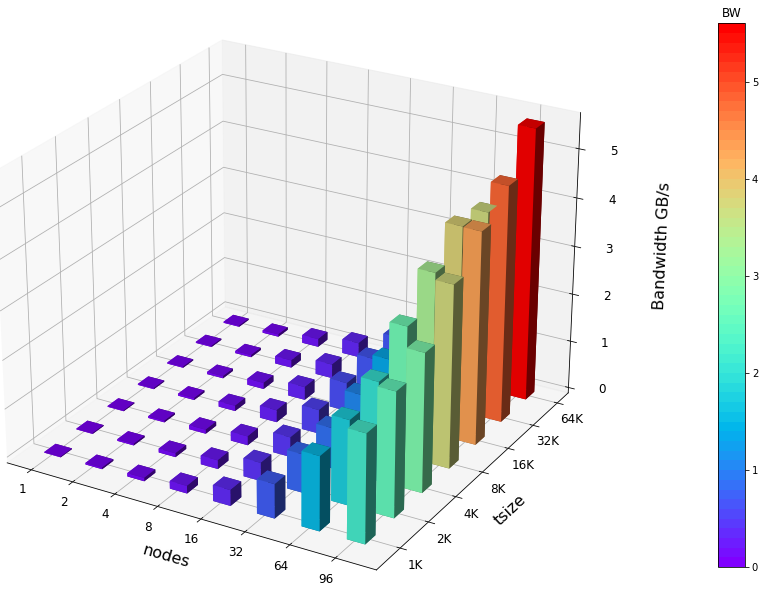

In [7]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_1_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
tsize = ['1K', '2K', '4K', '8K', '16K', '32K', '64K']
plots(HOME_seqread+'data_'+'write'+'.txt', nodes, tsize, 'tsize')

# BS = 4m, numTasks =4, transferSize=?

## READ

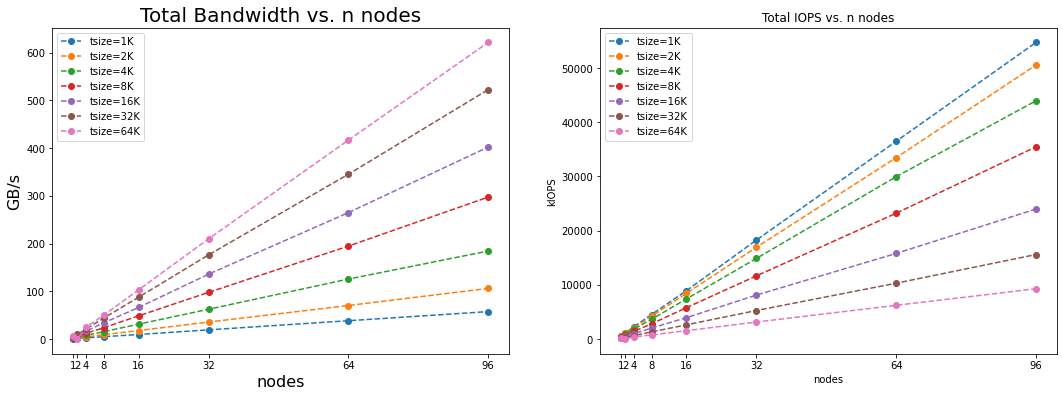

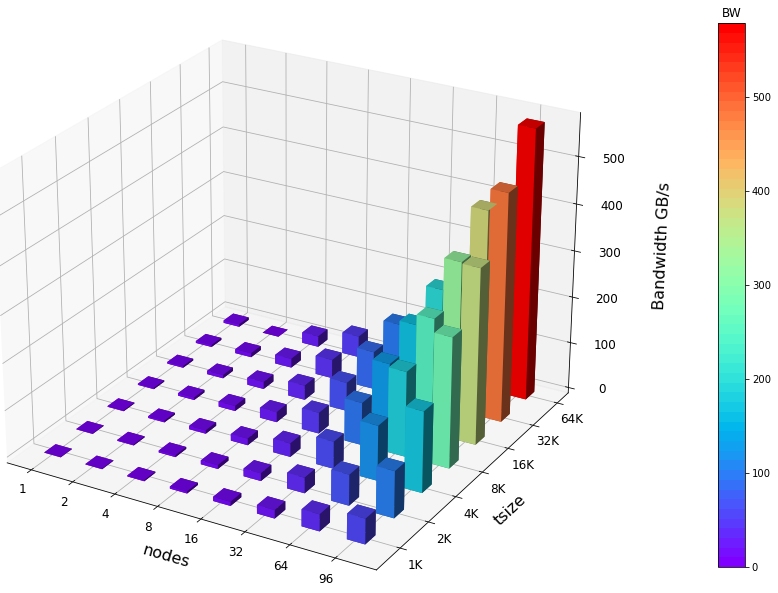

In [8]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_4_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
tsize = ['1K', '2K', '4K', '8K', '16K', '32K', '64K']
plots(HOME_seqread+'data_'+'read'+'.txt', nodes, tsize, 'tsize')

## WRITE

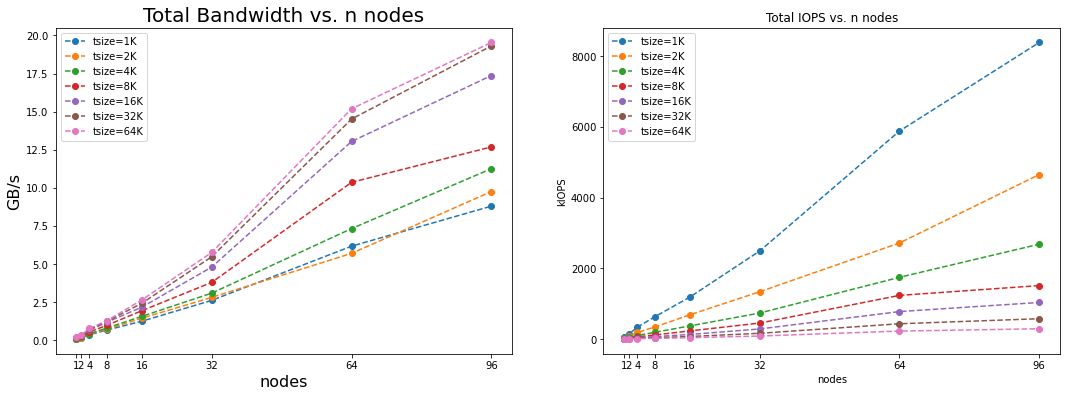

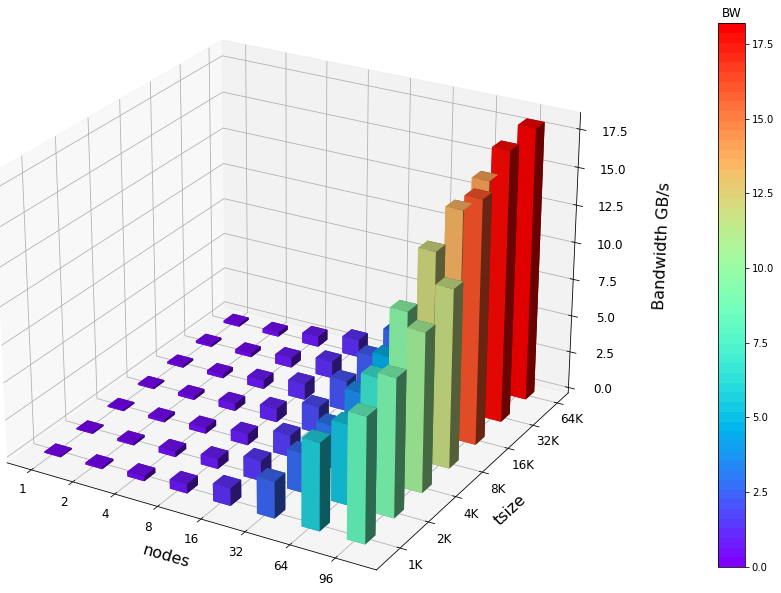

In [9]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_4_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
tsize = ['1K', '2K', '4K', '8K', '16K', '32K', '64K']
plots(HOME_seqread+'data_'+'write'+'.txt', nodes, tsize, 'tsize')

# BS = 4m, numTasks =16, transferSize = ?

# READ

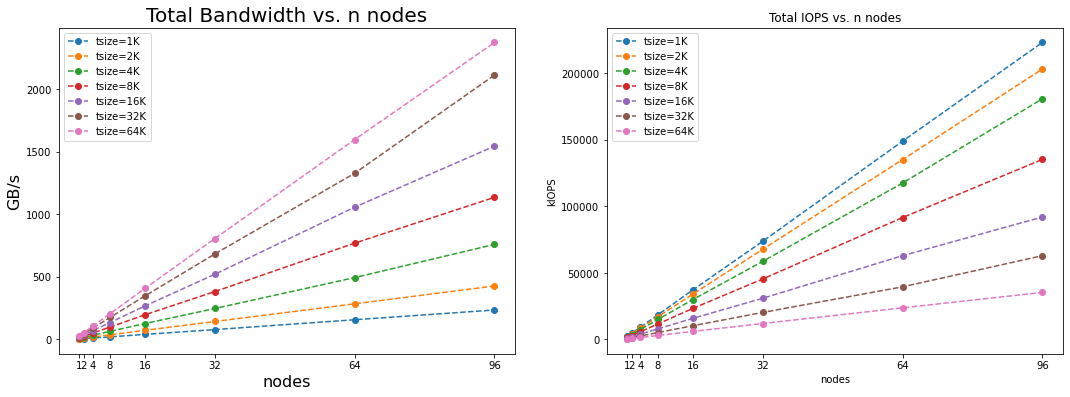

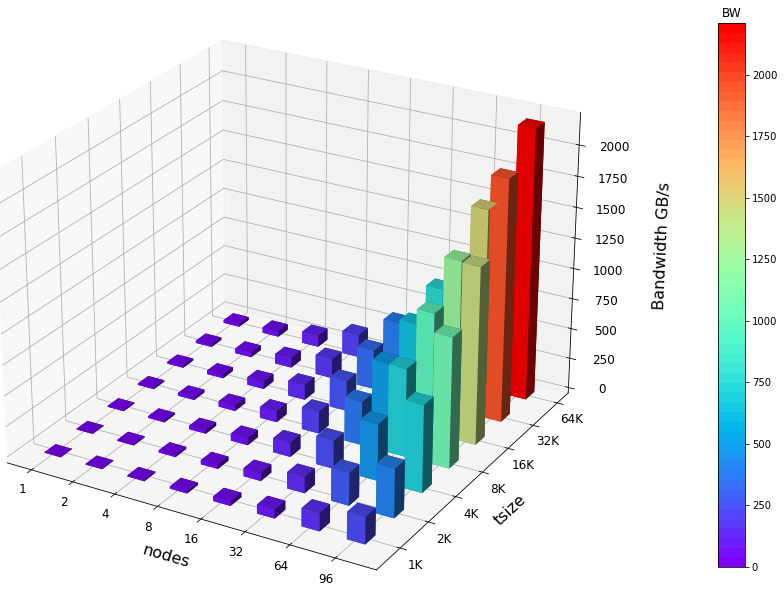

In [10]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_16_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
tsize = ['1K', '2K', '4K', '8K', '16K', '32K', '64K']
plots(HOME_seqread+'data_'+'read'+'.txt', nodes, tsize, 'tsize')

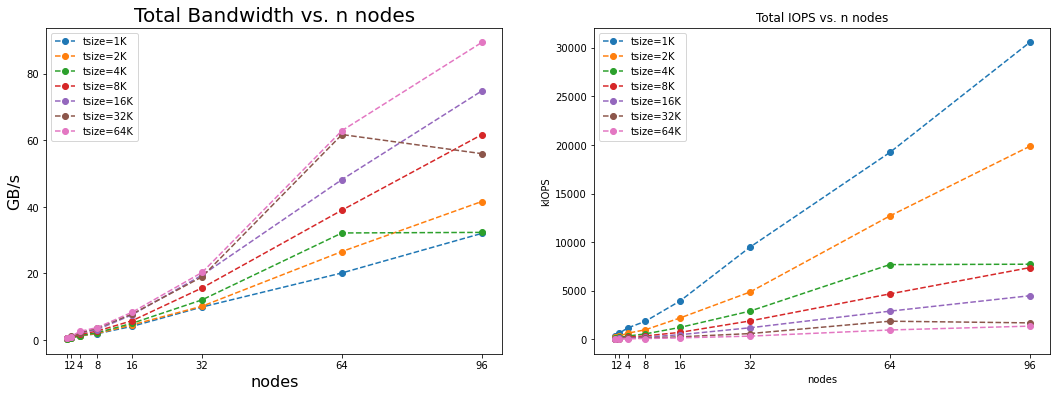

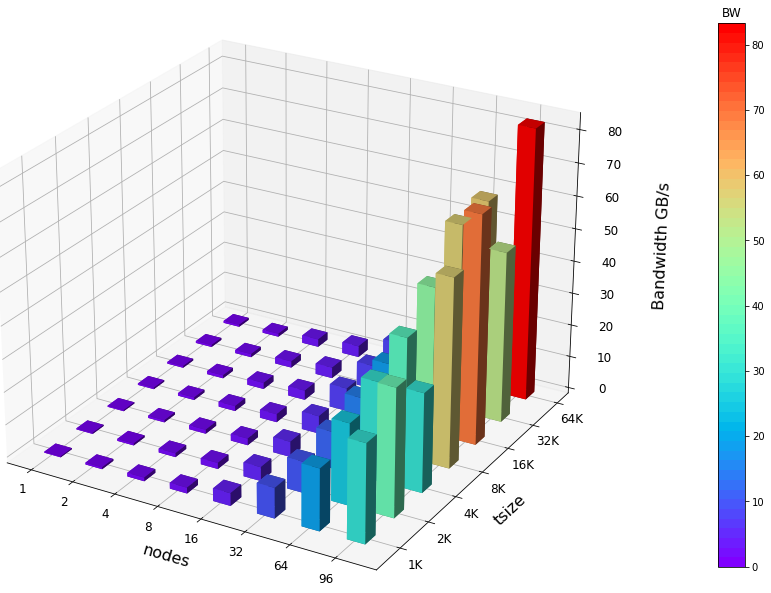

In [11]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/iortest_4m_fsize_16_task/'
nodes = [1, 2, 4, 8, 16, 32, 64, 96]
tsize = ['1K', '2K', '4K', '8K', '16K', '32K', '64K']
plots(HOME_seqread+'data_'+'write'+'.txt', nodes, tsize, 'tsize')

# SegmentCount = 1, BS = 1G, numTasks =1

## READ

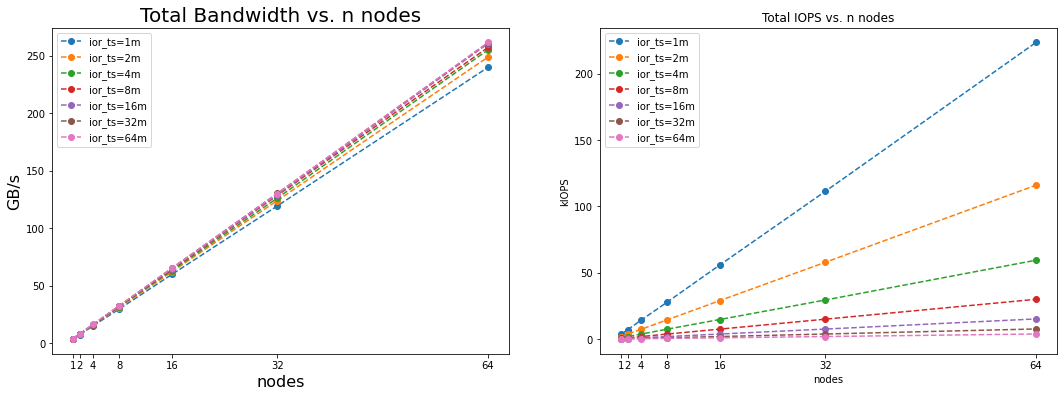

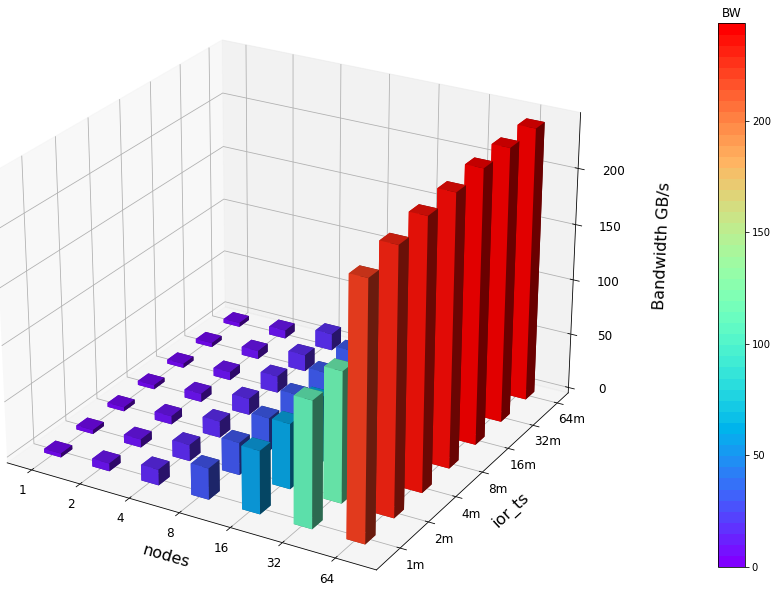

In [16]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/IORTEST_1g/'
nodes = [1, 2, 4, 8, 16, 32, 64]
fiojobs = ['1m', '2m', '4m', '8m', '16m', '32m', '64m']
plot_bw_iops(HOME_seqread, nodes, fiojobs, 'read')

## WRITE

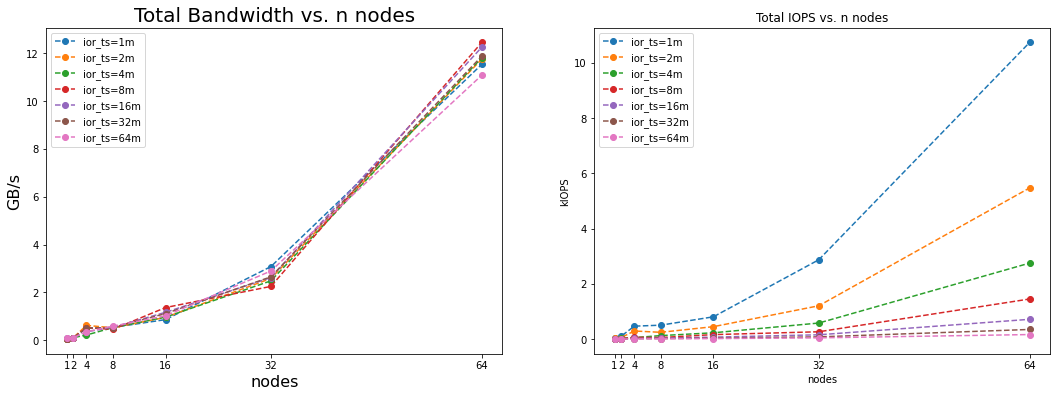

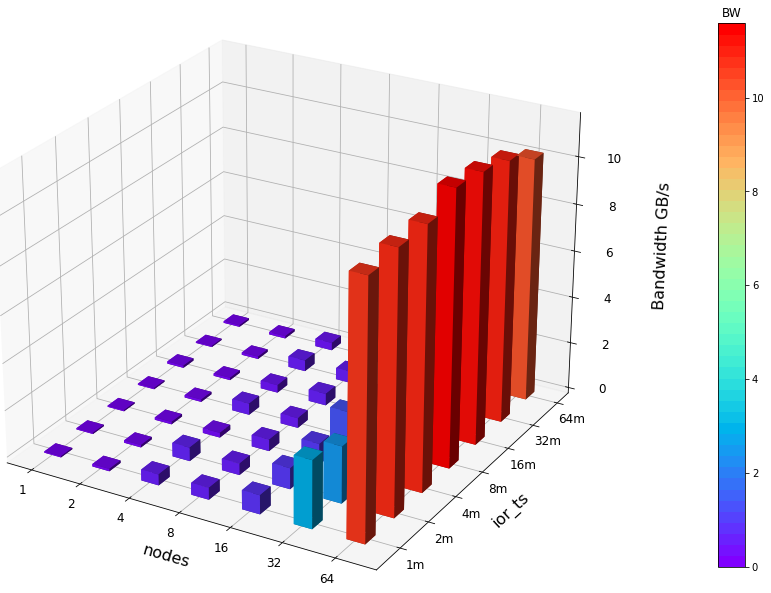

In [17]:
plot_bw_iops(HOME_seqread, nodes, fiojobs, 'write')

# SegmentCount = 1, BS = 1G, numTasks =2

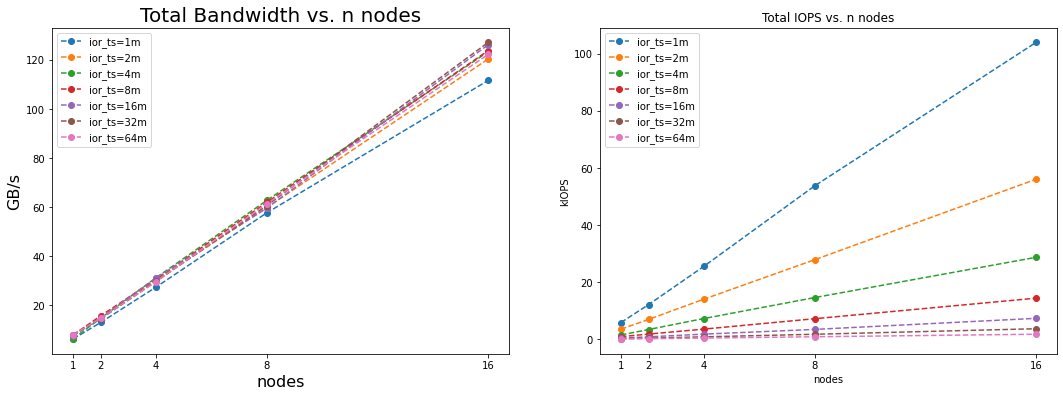

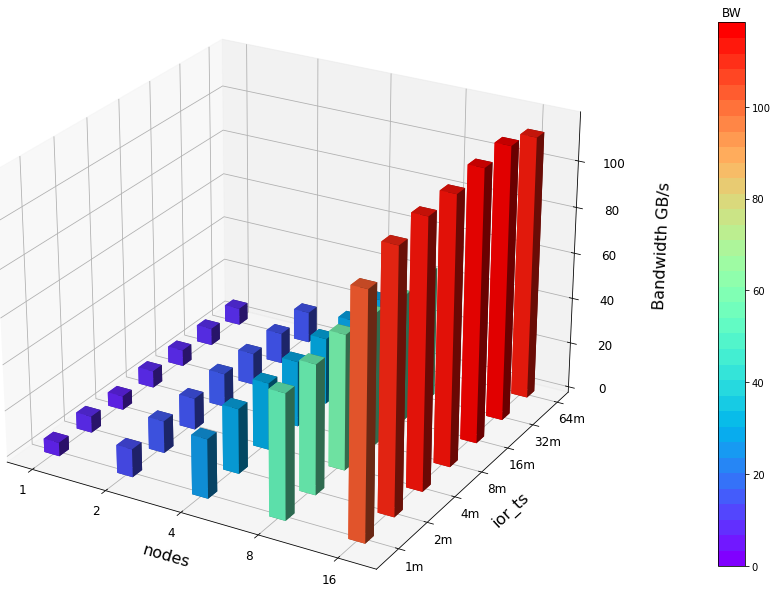

In [18]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/IORTEST_1g_2t/'
nodes = [1, 2, 4, 8, 16]
fiojobs = ['1m', '2m', '4m', '8m', '16m','32m', '64m']
plot_bw_iops(HOME_seqread, nodes, fiojobs, 'read')

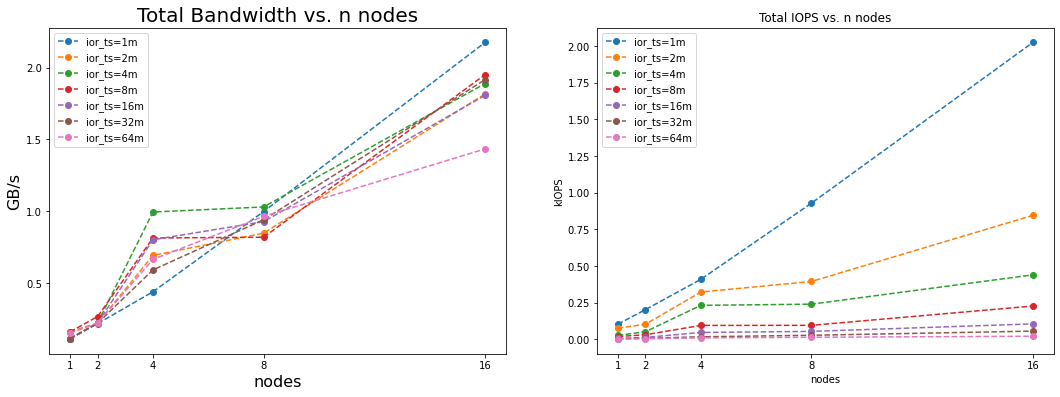

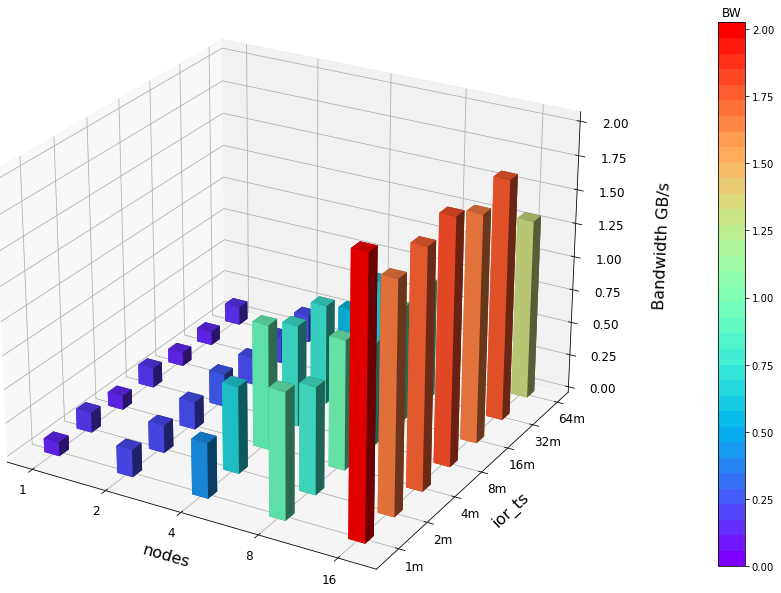

In [19]:
plot_bw_iops(HOME_seqread, nodes, fiojobs, 'write')

# SegmentCount = 1, BS = 4G, numTasks =1

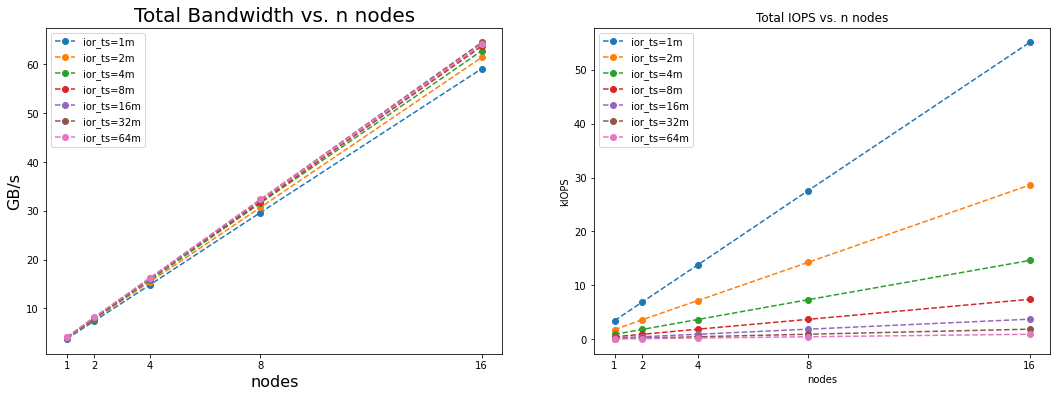

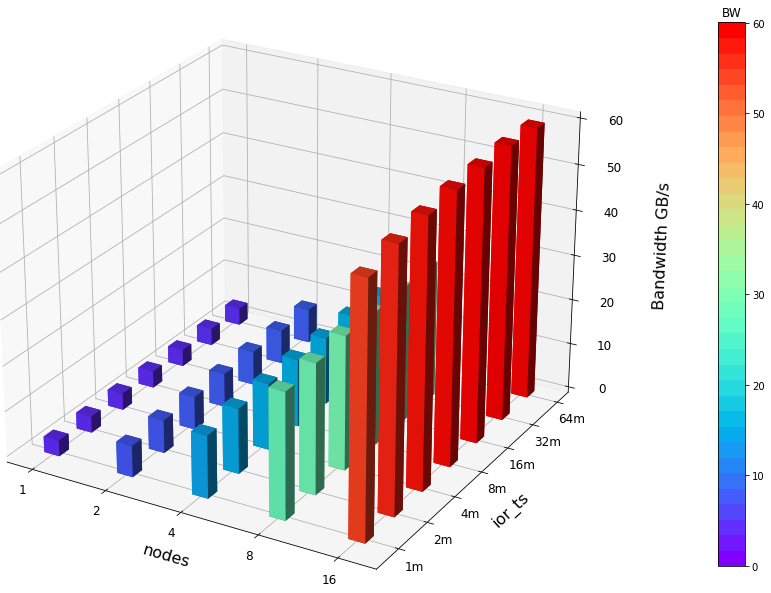

In [20]:
HOME_seqread = '/home/ccochato/Desktop/Computing/HPC/PROJECT/IOR/IORTEST_2g/'
nodes = [1, 2, 4, 8, 16]
fiojobs = ['1m', '2m', '4m', '8m', '16m', '32m', '64m']
plot_bw_iops(HOME_seqread, nodes, fiojobs, 'read')

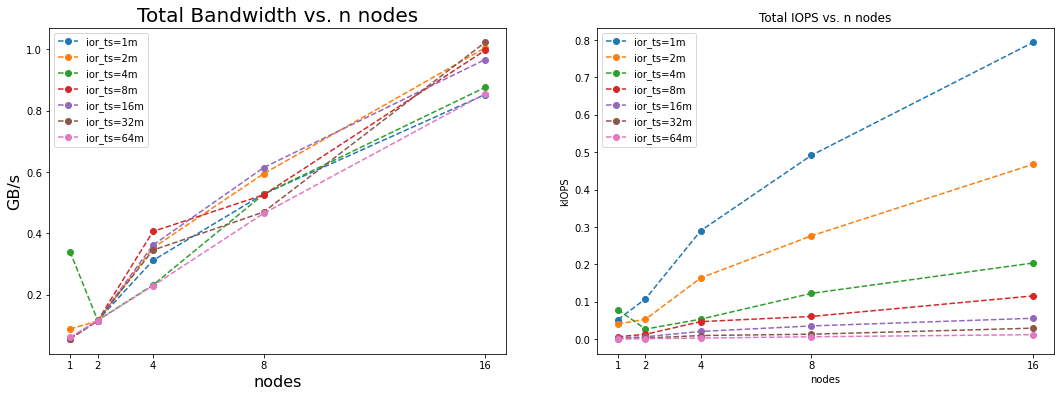

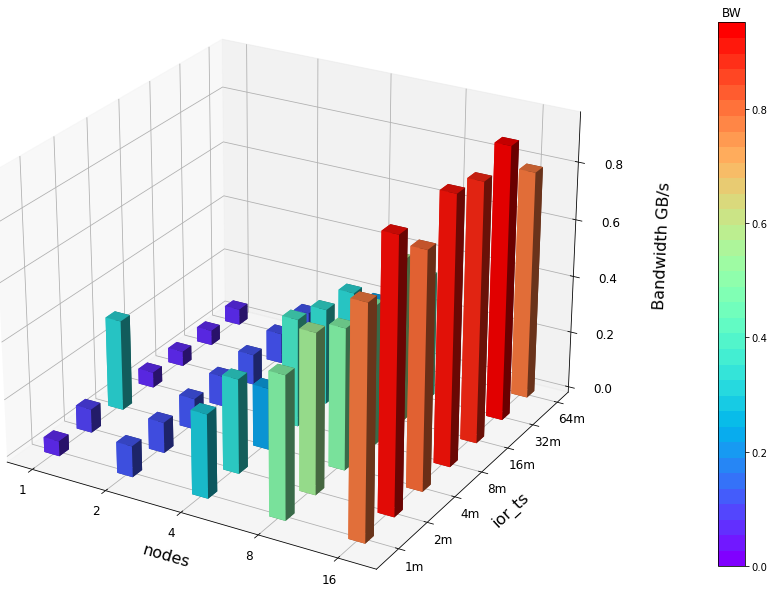

In [21]:
plot_bw_iops(HOME_seqread, nodes, fiojobs, 'write')